In [ ]:
! pip install -U scikit-learn
! conda install scikit-learn -y

Requirement already up-to-date: scikit-learn in /Users/craig/opt/anaconda3/lib/python3.7/site-packages (0.21.3)

In [2]:
import onnx
import numpy as np
from lime import lime_image
import netron
import os
from skimage.segmentation import mark_boundaries
from PIL import Image
import warnings
import onnxruntime as rt
from onnx import numpy_helper
import cv2
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import preprocessing
import tensorflow as tf
%matplotlib inline

In [3]:
'''
Boiler plate code provided by Microsoft Custom Vision Documentation.

Not currently in use.
'''
def convert_to_opencv(image):
    # RGB -> BGR conversion is performed as well.
    image = image.convert('RGB')
    r,g,b = np.array(image).T
    opencv_image = np.array([b,g,r]).transpose()
    return opencv_image

def crop_center(img,cropx,cropy):
    h, w = img.shape[:2]
    startx = w//2-(cropx//2)
    starty = h//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx]

def resize_down_to_1600_max_dim(image):
    h, w = image.shape[:2]
    if (h < 1600 and w < 1600):
        return image

    new_size = (1600 * w // h, 1600) if (h > w) else (1600, 1600 * h // w)
    return cv2.resize(image, new_size, interpolation = cv2.INTER_LINEAR)

def resize_to_224_square(image):
    h, w = image.shape[:2]
    return cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)

def update_orientation(image):
    exif_orientation_tag = 0x0112
    if hasattr(image, '_getexif'):
        exif = image._getexif()
        if (exif != None and exif_orientation_tag in exif):
            orientation = exif.get(exif_orientation_tag, 1)
            # orientation is 1 based, shift to zero based and flip/transpose based on 0-based values
            orientation -= 1
            if orientation >= 4:
                image = image.transpose(Image.TRANSPOSE)
            if orientation == 2 or orientation == 3 or orientation == 6 or orientation == 7:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
            if orientation == 1 or orientation == 2 or orientation == 5 or orientation == 6:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

In [4]:
session = tf.Session()

In [5]:
graph_def = tf.compat.v1.GraphDef()
labels = []

# These are set to the default names from exported models, update as needed.
filename = "./model/tensorflow/model.pb"
labels_filename = "./model/tensorflow/labels.txt"

# Import the TF graph
with tf.io.gfile.GFile(filename, 'rb') as f:
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

# Create a list of labels.
with open(labels_filename, 'rt') as lf:
    for l in lf:
        labels.append(l.strip())

In [29]:
imageFile = "./wolf/n02114548_13559.JPEG"

def preprocess(image,
                height,
                width,
                central_fraction=0.875,
                scope=None,
                central_crop=True,
                use_grayscale=False):
      with tf.name_scope(scope, 'eval_image', [image, height, width]):
        if image.dtype != tf.float32:
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        if use_grayscale:
            image = tf.image.rgb_to_grayscale(image)
    # Crop the central region of the image with an area containing 87.5% of
    # the original image.
        if central_crop and central_fraction:
            image = tf.image.central_crop(image, central_fraction=central_fraction)

        if height and width:
          # Resize the image to the specified height and width.
            image = tf.expand_dims(image, 0)
            image = tf.image.resize_bilinear(image, [height, width],
                                       align_corners=False)
        image = tf.squeeze(image, [0])
        return image

def transform_img_fn(path_list):
    out = []
    for path in path_list:
        image_raw = tf.image.decode_jpeg(open(path, 'rb').read(), channels=3)
        image = preprocess(image_raw, 224, 224)
        out.append(image)
    return session.run([out])[0]

images = transform_img_fn(["./wolf/n02114548_13559.JPEG"])
image_raw = tf.image.decode_jpeg(open(imageFile, 'rb').read(), channels=3)

In [27]:
# These names are part of the model and cannot be changed.
output_layer = 'loss:0'
input_node = 'Placeholder:0'

# def _init_feed_dict(images):
#     for image in images:
#         pass

def predict_fn(images):
    return session.run(prob_tensor, {input_node: preprocess(images) })

prob_tensor = session.graph.get_tensor_by_name(output_layer)
input_node = session.graph.get_tensor_by_name(input_node)
predictions, = predict_fn(images)

Classified as: Wolf

Husky 0.0012045600451529026
Wolf 0.9987953305244446


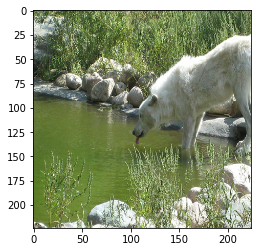

In [28]:
# Print the highest probability label
highest_probability_index = np.argmax(predictions)
print('Classified as: ' + labels[highest_probability_index])
print()

# Or you can print out all of the results mapping labels to probabilities.
label_index = 0
for p in predictions:
    truncated_probablity = np.float64(np.round(p,8))
    print (labels[label_index], truncated_probablity)
    label_index += 1
    
plt.imshow(images[0])

In [23]:
# image = images[0]
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image_raw, predict_fn, num_samples=100)

150528


ValueError: Found input variables with inconsistent numbers of samples: [100, 10]